In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from concurrent.futures import ThreadPoolExecutor, as_completed

import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from multiprocessing import Pool
from concurrent.futures import ThreadPoolExecutor, as_completed

from keras.models import Model
from keras.optimizers import Adam
from keras.models import load_model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, LSTM, BatchNormalization, Dropout, Dense, Add, Flatten

from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

2024-09-22 03:01:25.184271: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-22 03:01:25.237308: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-22 03:01:25.237349: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-22 03:01:25.237382: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-22 03:01:25.246630: I tensorflow/core/platform/cpu_feature_g

In [2]:
NUM_CLASSES = 2
CLASSES = np.array(['Legitimate', 'Suspicious'])
DATASET_DIR = "./"
VECTOR_LENGTH = 1 * 165

def csvToVector(file_path):
    data = pd.read_csv(file_path, header=None)
    vector = data.values.flatten()
    return vector

def process_file(class_idx, file_path):
    vector = csvToVector(file_path)
    return (vector, class_idx)

def load_data(dataset_dir):
    X = []
    y = []
    subdirs = ['benign_cms4', 'malware_cms4']
    futures = []

    with ThreadPoolExecutor() as executor:
        for class_idx, class_name in enumerate(subdirs):
            class_dir = os.path.join(dataset_dir, class_name)
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.csv'):
                    file_path = os.path.join(class_dir, file_name)
                    futures.append(executor.submit(process_file, class_idx, file_path))

        for future in as_completed(futures):
            vector, class_idx = future.result()
            X.append(vector)
            y.append(class_idx)

    X = np.array(X)
    y = np.array(y)
    return X, y

In [3]:
X, y = load_data(DATASET_DIR)

In [4]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=42)

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train = X_train / 299.0
#X_val = X_val / 299.0
X_test = X_test / 299.0

y_train = to_categorical(y_train, 2)
#y_val = to_categorical(y_val, 2)
y_test = to_categorical(y_test, 2)

In [5]:
cp_model = load_model('CMS4_LSTM_CheckPoint.h5')

2024-09-22 03:01:41.160485: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31350 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:d8:00.0, compute capability: 7.0


2024-09-22 03:01:42.366088: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907


38/38 [==============================] - 1s 3ms/step


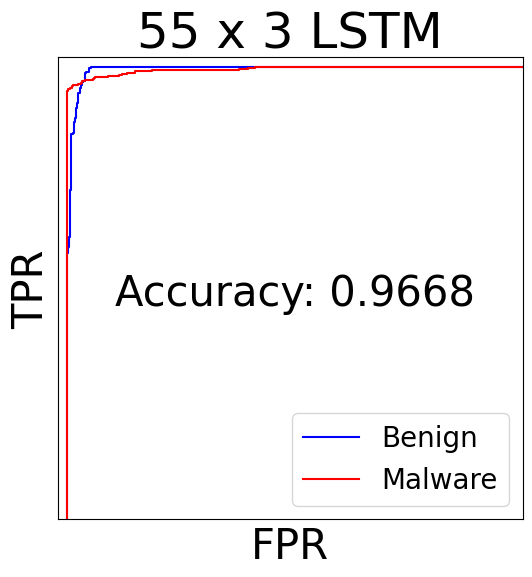

In [6]:
y_pred_proba = cp_model.predict(X_test)

y_test_binary = np.argmax(y_test, axis=1)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    if i == 1:
        fpr[i], tpr[i], _ = roc_curve(y_test_binary, y_pred_proba[:, i])
    else:
        fpr[i], tpr[i], _ = roc_curve(1 - y_test_binary, y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

class_labels = ['Benign', 'Malware']
colors = ['blue', 'red']

plt.rcParams.update({'font.size': 30})
plt.figure(figsize=(6, 6))
for i in range(2):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f'{class_labels[i]}')

plt.plot([0, 1], [0, 1], 'None', lw=2)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xticks([])
plt.yticks([])

accuracy = np.mean(y_test_binary == np.argmax(y_pred_proba, axis=1))
plt.text(0.5, 0.5, f'Accuracy: {accuracy:.4f}', fontsize=30, ha='center', va='center')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('55 x 3 LSTM')
plt.legend(fontsize=20, loc="lower right")
plt.savefig('roc_2_lstm.pdf', dpi=1000)
plt.show()

In [7]:
y_pred = cp_model.predict(X_test)
y_pred_classes = tf.argmax(y_pred, axis=1)
y_test_classes = tf.argmax(y_test, axis=1)

print(classification_report(y_test_classes, y_pred_classes, digits=4))
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

class_labels = ['Legitimate', 'Suspicious']

conf_matrix_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)

print("Confusion Matrix:")
print(conf_matrix_df)

38/38 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0     0.9694    0.9663    0.9678       623
           1     0.9641    0.9674    0.9658       583

    accuracy                         0.9668      1206
   macro avg     0.9668    0.9669    0.9668      1206
weighted avg     0.9668    0.9668    0.9668      1206

Confusion Matrix:
            Legitimate  Suspicious
Legitimate         602          21
Suspicious          19         564
